In [63]:
import pytraj as pt
import parmed as pmd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import networkx as nx
import scipy
import pickle as pkl
from tqdm.notebook import tqdm
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from scipy import exp
from kneed import KneeLocator as KneedLoc

In [64]:
# %matplotlib widget

In [65]:
plt.rcParams['font.family'] = 'Helvetica'

<h1> Graph Normalization and Thresholding </h1>

In [66]:
def compute_normalized_graph(matrix):
    row_sums = matrix.sum(axis=1)
    size = matrix.shape[0]
    new_matrix = np.zeros((size,size))
    for x,row in enumerate(matrix):
        #for every column's row
        for y, val in enumerate(row):
            #for every value in row
            current = val / row_sums[x] if row_sums[x] != 0 else 0
            new_matrix[x,y] = max([current,new_matrix[y,x]])
            new_matrix[y,x] = max([current,new_matrix[x,y]])

    return new_matrix

In [67]:
def threshold_normalized_graph(matrix, cutoff):
    size = matrix.shape[0]
    new_matrix = np.zeros((size,size))
    for x,row in enumerate(matrix):
        for y, val in enumerate(row):
            new_matrix[x,y] = 1 if matrix[x,y] > cutoff else 0

    return new_matrix

<h1> Pairwise Energy Tensor Analysis </h1>

In [68]:
def thresh_and_norm_matrix(tensor,channel,threshold):
    #same function as above, just quicker to access here outside of the tensor class
    '''
    channel (int): the energy channel to compute for
    threshold (float): the cutoff value

    returns : (numpy.ndarray) matrix of matrices summed over common edges, normalized,
    and thresholded
    '''
    energy_tensor = torch.Tensor(tensor[:,channel])
    sum_matrix = torch.sum(energy_tensor, dim=0).numpy()
    normalized = compute_normalized_graph(sum_matrix)
    #thresholded is binary
    thresholded = threshold_normalized_graph(normalized,threshold)
    weighted_threshold = thresholded * normalized
    return (thresholded,weighted_threshold)

<h1> Heat Kernel Analysis:</h1>

### Heat Kernel PCA (See: https://link.springer.com/chapter/10.1007/11815921_18)

In [69]:
def matrix_exponentiation(eigenvectors,eigenvalues,t):
    '''
    Raise e^matrix where matrix is a square
    '''
    shape = eigenvectors.shape[0]
    processed_eigenvalues = np.exp(-t*eigenvalues)
    e_diagonal = np.diag(processed_eigenvalues)
    return eigenvectors.dot(e_diagonal).dot(eigenvectors.transpose())

def get_heat_kernel(matrix,t):
    laplacian = scipy.sparse.csgraph.laplacian(matrix,normed=True)
    (eigenvalues,eigenvectors) = np.linalg.eigh(laplacian)
    x = matrix_exponentiation(eigenvectors,eigenvalues,t)
    x = np.round(x, decimals = 6)
    return x

def kernel_from_energy_tensor_thresh(tensor,threshold,time):
    kernels = np.zeros((tensor.shape[0], tensor.shape[2], tensor.shape[2]))
    for i, matrix in enumerate(tensor):
        normalized = compute_normalized_graph(matrix)
        thresholded = threshold_normalized_graph(normalized,threshold)
        final_mat = thresholded * normalized
        kernel = get_heat_kernel(final_mat, time)
        kernels[i] = kernel

    return kernels

In [70]:
from sklearn.decomposition import PCA

def get_pca(kernel,dim):
    pca = PCA(n_components=dim)
    pca.fit(kernel)
    transformed = pca.transform(kernel)
    return (transformed, pca.explained_variance_)

In [71]:
def make_shared_pca_df(kernels, num_components, show_var=False):
    dfs = []
    eigens=[]
    for kernel in kernels:
        (pcs, var) = get_pca(kernel, num_components)
        df = pd.DataFrame(pcs)
        dfs.append(df)
        if show_var:
            eigens+=[var]

    return (eigens, pd.concat(dfs))

# Energy Tensors:

In [72]:
#etensor indexing: frame, row, column

In [73]:
def LoadData(file):
    toReturn = []
    with np.load(file) as data:
        lst = data.files
        for item in lst:
            toReturn.append(data[item])
    if len(toReturn) > 1: raise ValueError(f"file has length {len(toReturn)}")
    return toReturn[0]

In [74]:
# wt_etensor=np.load('/home/student5/Desktop/Energetics/elec_1.npz')
# for x in wt_etensor:
#     print(x)

path = "/home/student5/Desktop/Energetics/zfshomes/sstetson/End_Fall23-Pres/Analysis/DBD/ff14SB/Energetics/"

wt_etensor = [
    LoadData(path + f"WT/Rep1/1-200/normal/elec_1-194/elec_{x}.npz") for x in range(1, 201)
] + [
    LoadData(path + f"WT/Rep1/201-400/normal/elec_1-194/elec_{x}.npz") for x in range(201, 401)
] + [
    LoadData(path + f"WT/Rep1/401-600/normal/elec_1-194/elec_{x}.npz") for x in range(401, 601)
] + [
    LoadData(path + f"WT/Rep1/601-800/normal/elec_1-194/elec_{x}.npz") for x in range(601, 801)
] + [
    LoadData(path + f"WT/Rep1/801-1000/normal/elec_1-194/elec_{x}.npz") for x in range(801, 1001)
] + [
    LoadData(path + f"WT/Rep2/1-200/normal/elec_1-194/elec_{x}.npz") for x in range(1, 201)
] + [
    LoadData(path + f"WT/Rep2/201-400/normal/elec_1-194/elec_{x}.npz") for x in range(201, 401)
] + [
    LoadData(path + f"WT/Rep2/401-600/normal/elec_1-194/elec_{x}.npz") for x in range(401, 601)
] + [
    LoadData(path + f"WT/Rep2/601-800/normal/elec_1-194/elec_{x}.npz") for x in range(601, 801)
] + [
    LoadData(path + f"WT/Rep2/801-1000/normal/elec_1-194/elec_{x}.npz") for x in range(801, 1001)
] + [
    LoadData(path + f"WT/Rep3/1-200/normal/elec_1-194/elec_{x}.npz") for x in range(1, 201)
] + [
    LoadData(path + f"WT/Rep3/201-400/normal/elec_1-194/elec_{x}.npz") for x in range(201, 401)
] + [
    LoadData(path + f"WT/Rep3/401-600/normal/elec_1-194/elec_{x}.npz") for x in range(401, 601)
] + [
    LoadData(path + f"WT/Rep3/601-800/normal/elec_1-194/elec_{x}.npz") for x in range(601, 801)
] + [
    LoadData(path + f"WT/Rep3/801-1000/normal/elec_1-194/elec_{x}.npz") for x in range(801, 1001)
] + [
    LoadData(path + f"WT/Rep4/1-200/normal/elec_1-194/elec_{x}.npz") for x in range(1, 201)
] + [
    LoadData(path + f"WT/Rep4/201-400/normal/elec_1-194/elec_{x}.npz") for x in range(201, 401)
] + [
    LoadData(path + f"WT/Rep4/401-600/normal/elec_1-194/elec_{x}.npz") for x in range(401, 601)
] + [
    LoadData(path + f"WT/Rep4/601-800/normal/elec_1-194/elec_{x}.npz") for x in range(601, 801)
] + [
    LoadData(path + f"WT/Rep4/801-1000/normal/elec_1-194/elec_{x}.npz") for x in range(801, 1001)
]

wt_etensor = np.array(wt_etensor)
wt_etensor

array([[[0.        , 0.01941373, 0.01205954, ..., 0.0038218 ,
         0.00498352, 0.00538636],
        [0.01941373, 0.        , 0.0165852 , ..., 0.00366992,
         0.00484092, 0.00522209],
        [0.01205954, 0.0165852 , 0.        , ..., 0.00342556,
         0.00449098, 0.00490984],
        ...,
        [0.0038218 , 0.00366992, 0.00342556, ..., 0.        ,
         0.02678466, 0.0283807 ],
        [0.00498352, 0.00484092, 0.00449098, ..., 0.02678466,
         0.        , 0.02640505],
        [0.00538636, 0.00522209, 0.00490984, ..., 0.0283807 ,
         0.02640505, 0.        ]],

       [[0.        , 0.01698401, 0.01116091, ..., 0.00320898,
         0.0041294 , 0.00438208],
        [0.01698401, 0.        , 0.01468785, ..., 0.00334242,
         0.00437367, 0.00462664],
        [0.01116091, 0.01468785, 0.        , ..., 0.00324862,
         0.00427939, 0.00456625],
        ...,
        [0.00320898, 0.00334242, 0.00324862, ..., 0.        ,
         0.02635478, 0.02542504],
        [0.0

### creating thresholded and normalized matrices of the energy tensors:
##### this is done to check where we might want to cut off values in our subsequent tensor generation

In [75]:
def thresh_check(data, bins=50, thresh=None):
    fig,ax=plt.subplots(layout="constrained")
    x = ax.hist(data.flatten(), bins=bins)
    ax.set_xlabel("Normalized Edge Weight Value")
    ax.set_ylabel("Number of Edges")
    if thresh: ax.vlines([thresh], 0, 1, colors="red", linestyles="-", transform=ax.get_xaxis_transform())
    fig.suptitle(f"WT DBD Distribution of Edge Weight: Thresh={thresh}")
    plt.savefig("WT_DBD_EdgeWeightDist.png", bbox_inches="tight", dpi=300, transparent=False, facecolor="white")
    
    return x

(array([1.55200e+04, 4.76580e+04, 2.61534e+05, ..., 0.00000e+00,
        0.00000e+00, 4.00000e+00]),
 array([0.        , 0.00102699, 0.00205397, ..., 0.0492953 , 0.05032229,
        0.05134927]),
 <BarContainer object of 50 artists>)

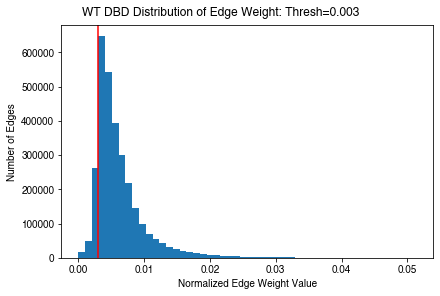

In [76]:
thresh_check(wt_etensor[::50], thresh=0.003, bins=50)

### Determining Time and Thresh Parameters

In [92]:
time = 5
thresh = 0.003
num_of_pcs = 10
etensor = wt_etensor

kernel = kernel_from_energy_tensor_thresh(etensor,thresh,time)
eigens, pcs = make_shared_pca_df(kernel,num_of_pcs,show_var=True)

eigens_df = pd.DataFrame(eigens)
mean_n_eigens = eigens_df.mean(axis=0)

Elbow Eigenvalue: 3


/tmp/ipykernel_96128/3156764766.py:4: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.savefig("WT_PCA_Knee.png", bbox_inches="tight", dpi=300)
/home/student5/anaconda3/envs/AmberTools23/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


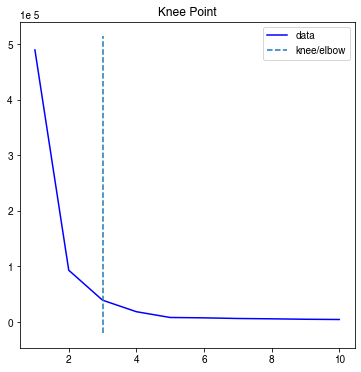

In [93]:
kneedl= KneedLoc(range(1,num_of_pcs+1), mean_n_eigens, S=1, curve="convex", direction="decreasing")
print('Elbow Eigenvalue:', round(kneedl.elbow,3))
kneedl.plot_knee()
plt.savefig("WT_PCA_Knee.png", bbox_inches="tight", dpi=300)

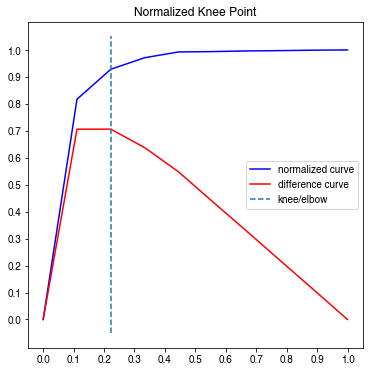

In [94]:
kneedl.plot_knee_normalized()

## PCA Embedding Heat Kernels:

In [95]:
#getting the principle components from the heatkernel
#changed the last argument to 2 and it changed stuff. Ask Dylan how many "components" I should be doing (2 or 3)? We want 3 typically
(_,wt_pcs) = make_shared_pca_df(kernel,3)

In [96]:
wt_pcs

,0,1,2
0,-0.004639,0.001099,-0.001663
1,-0.004528,0.001039,-0.001674
2,-0.005332,0.001374,-0.001463
3,-0.004492,0.002260,-0.000620
4,0.005237,0.000712,0.000008
...,...,...,...
189,0.000780,-0.002297,0.002803
190,-0.000584,-0.001811,0.003635
191,-0.003703,-0.002284,0.003142
192,0.000370,-0.001914,0.002474


## System Heat Kernel Shared PCA Plots

In [97]:
#assigns res number to each pcs embedding
def embedded_res_assign(frame_tot,res_tot,df):
    lst=np.zeros(frame_tot*res_tot)
    n=res_tot
    res_idx=[]
    i=1
    res=1
    while i<=len(lst):
        if res>res_tot:
            res=1
            res_idx.append(res)
        else:
            res_idx.append(res)
        res+=1
        i+=1
    df['res'] =res_idx
    return df

def embedded_frame_assign(frame_tot,res_tot,df):
    lst=np.zeros(frame_tot*res_tot)
    n=res_tot
    frame_idx=[]
    i=1
    frame=0
    while i<=len(lst):
        if (i)%n==0:
            frame_idx.append(frame)
            frame+=1
        else:
            frame_idx.append(frame)
        i+=1
    df['frame'] =frame_idx
    return df


def heat_map(kernel,pcs):
    diag_els=[]
    for matrix in kernel[:]:
        diag_element=np.diag(matrix)
        diag_els+=[diag_element]
    diag_flat=np.concatenate(diag_els)
    #set the column called 'heat' to the flattened diagonal matrix consisting of the diagonal elements of the kernel
    pcs['heat'] =diag_flat
    return pcs

#range_color1=[0.0112,0.0134]
range_color1=[]
xrng=[-0.013, 0.024]
yrng=[-0.013, 0.015]
def heat_map_plot(kernel,pcs,pc_b,title_name):
    heat_pcs=heat_map(kernel,pcs)
    heat_pcs_res0=embedded_res_assign(100,199,heat_pcs)
    heat_pcs_res=embedded_frame_assign(100,199,heat_pcs)
    fig=px.scatter(heat_pcs_res, x= 0, y= pc_b, color="heat",range_color=range_color1,hover_data=["heat","res","frame"], labels={ "0": "PC1","2": "PC3"},title=title_name)
    fig.update_layout(title_x=0.5)
    fig.update_layout(title_yanchor="top")
    fig.update_traces(marker=dict(size=10))
    fig.update_xaxes(range=xrng)
    fig.update_yaxes(range=yrng)
    fig.update_layout(font=dict(
        family="Arial",
        size=16))
    fig.show()

def three_dim_heat_map_plot(kernel,pcs):
    heat_pcs=heat_map(kernel,pcs)
    heat_pcs_res0=embedded_res_assign(100,199,heat_pcs)
    heat_pcs_res=embedded_frame_assign(100,199,heat_pcs)
    fig=px.scatter_3d(pcs, x=0, y=1, z=2,color="heat",hover_data=["heat","res","frame"])
    fig.update_traces(marker_size = 3)
    fig.show()

def heat_map_plot_resid(kernel,pcs,pc_b):
    heat_pcs=heat_map(kernel,pcs)
    heat_pcs_res=embedded_res_assign(100,199,heat_pcs)
    fig=px.scatter(heat_pcs_res, x= 0, y= pc_b, color="res",color_continuous_scale=px.colors.sequential.Turbo)
    fig.update_traces(marker=dict(size=10))

    fig.show()

def heat_res_frame_map(kernel,pcs,num_frame,num_res):
    heat_pcs=heat_map(kernel,pcs)
    heat_pcs_res=embedded_res_assign(num_frame,num_res,heat_pcs)
    heat_pcs_res_frame=embedded_frame_assign(num_frame,num_res,heat_pcs)
    return heat_pcs_res_frame



In [98]:
wt_heat = heat_res_frame_map(kernel, wt_pcs, 4000, 194)

In [99]:
wt_heat.to_csv("/home/student5/Desktop/Energetics/Processed/DBD_WT_Long_Elec_1-194.csv")

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(wt_heat[0], wt_heat[1], wt_heat[2], c=wt_heat["heat"], cmap="inferno")